## Final Code That Puts Everything Together

### Load in packages that we will use

In [13]:
using MLDatasets, Plots, LinearAlgebra, Clustering, ImageCore, Images

### Load in and plot dataset

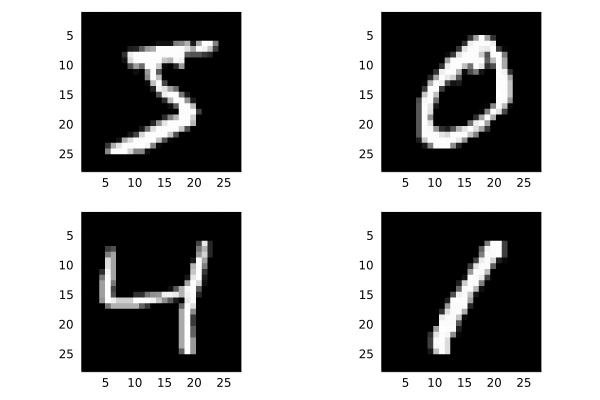

In [5]:
train_x, train_y = MNIST.traindata()
p1 = plot(MNIST.convert2image(MNIST.traintensor(1)))
p2 = plot(MNIST.convert2image(MNIST.traintensor(2)))
p3 = plot(MNIST.convert2image(MNIST.traintensor(3)))
p4 = plot(MNIST.convert2image(MNIST.traintensor(4)))
plot(p1, p2, p3, p4, layout = (2, 2), legend = false)

### Use SVD to reduce an image

In [27]:
test_svd = svd(MNIST.traintensor(3))

SVD{Float32, Float32, Matrix{Float32}}
U factor:
28×28 Matrix{Float32}:
  0.0          0.0         0.0        …  0.0  0.0  0.0  0.0   0.0
  0.0          0.0         0.0           0.0  0.0  0.0  0.0   0.0
  0.0          0.0         0.0           0.0  0.0  0.0  0.0   0.0
 -0.182142     0.0680845   0.0688385     0.0  0.0  0.0  0.0  -7.28935f-7
 -0.420267     0.391895   -0.01179       0.0  0.0  0.0  0.0   7.77794f-7
 -0.276594     0.291614    0.0945823  …  0.0  0.0  0.0  0.0  -6.00972f-7
 -0.100804    -0.023286    0.268303      0.0  0.0  0.0  0.0   0.0965789
 -0.100804    -0.0232859   0.268302      0.0  0.0  0.0  0.0  -0.779866
 -0.100804    -0.023286    0.268303      0.0  0.0  0.0  0.0   0.389621
 -0.127677    -0.0277783   0.325862      0.0  0.0  0.0  0.0   0.11158
 -0.112057    -0.0174656   0.302987   …  0.0  0.0  0.0  0.0   0.310698
 -0.120131    -0.0183688   0.300249      0.0  0.0  0.0  0.0   0.0317984
 -0.112919    -0.0136438   0.27866       0.0  0.0  0.0  0.0  -0.262639
  ⋮          

4


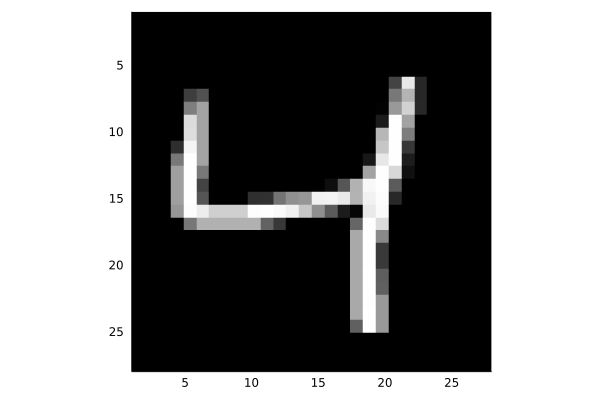

In [35]:
reconstructed_test_svd = transpose((test_svd.U * Diagonal(test_svd.S) * test_svd.Vt))
println(MNIST.trainlabels(3))
plot(Gray.(reconstructed_test_svd))

### Using "low rank" approximation for images

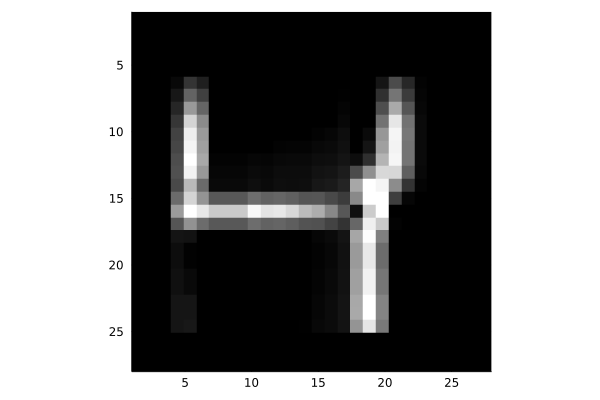

In [56]:
# rank 3 approximation for test_svd
test_svd_3 = transpose(test_svd.U[:, 1:3] * Diagonal(test_svd.S[1:3]) * test_svd.Vt[1:3, :])
plot(Gray.(test_svd_3))

### Run K-Means on dimensionally reduced images

In [ ]:
kmeans()